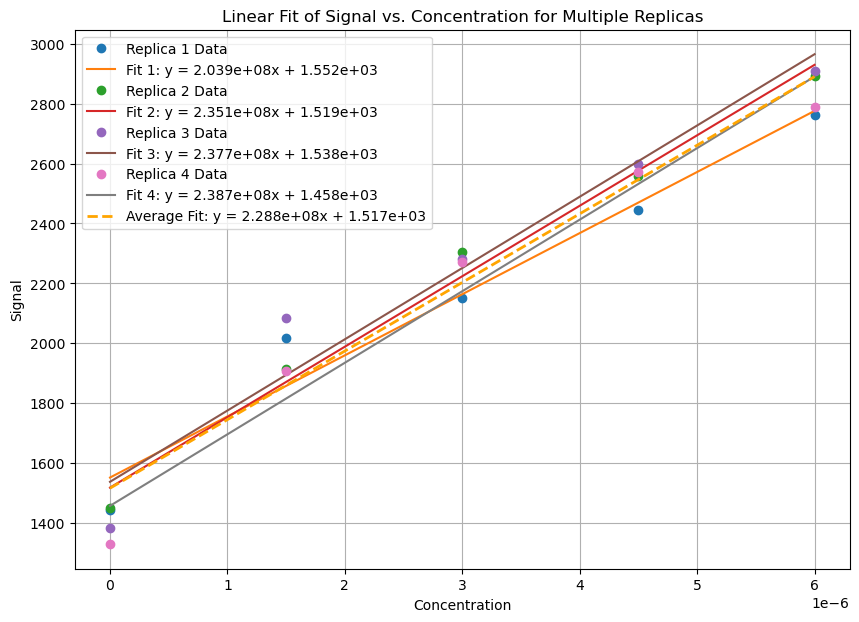

4 out of 4 replicas were retained.
Results saved to ./data/resutls/dye_alone_linear_fit_results.txt


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, ttest_1samp, t
from datetime import datetime

# Set the base directory for input and output files
base_dir = './data'
input_file_name = 'merged_dye_alone.txt'
output_file_name = 'dye_alone_linear_fit_results.txt'

#################################################################################################################
# Do NOT change code after this line
#################################################################################################################

# File paths
file_path = os.path.join(base_dir, input_file_name)
output_file_path = os.path.join(base_dir, 'resutls', output_file_name)

# Function to calculate the 95% prediction interval upper and lower bounds
def prediction_interval(data, avg_value):
    """
    Calculates the 95% prediction interval for the given data, with a minimum range of ±25% around the average.
    """
    n = len(data)
    mean = np.mean(data)
    if n > 1:
        std_dev = np.std(data, ddof=1)
        margin_of_error = std_dev * np.sqrt(1 + 1/n) * t.ppf(0.975, n-1)
        lower_bound = mean - margin_of_error
        upper_bound = mean + margin_of_error
        # Apply at least ±25% range around the average value
        lower_bound = min(lower_bound, avg_value * 0.75)
        upper_bound = max(upper_bound, avg_value * 1.25)
    else:
        # For single data point case
        margin_of_error = "not applicable"
        std_dev = "not applicable"
        lower_bound = "not applicable"
        upper_bound = "not applicable"
    return mean, lower_bound, upper_bound, std_dev

# Load data from the file
def load_data(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
        return lines
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

# Function to split the data into replicas based on "var" or concentration reset (0.0 value)
def split_replicas(data):
    if data is None:
        print("Data is None. Cannot split replicas.")
        return None

    replicas = []
    current_replica = []
    use_var_signal_split = False

    # Check if "var" is detected in the file
    for line in data:
        if "var\tsignal" in line.lower():
            use_var_signal_split = True
            break

    for line in data:
        # Detect "var" indicating a new replica
        if "var" in line.lower():
            if current_replica:  # Save current replica if it has data
                replicas.append(np.array(current_replica))
                current_replica = []
        else:
            try:
                # Parse the data as floats
                x, y = map(float, line.split())

                if use_var_signal_split:
                    # If splitting based on "var," add data directly to the current replica
                    current_replica.append((x, y))
                else:
                    # Check for a concentration reset (0.0 value) if "var" was not found
                    if x == 0.0 and current_replica:
                        replicas.append(np.array(current_replica))
                        current_replica = []
                    # Add the current data point to the replica
                    current_replica.append((x, y))
            except ValueError:
                continue  # Ignore non-numeric lines

    # Save the last replica if it exists
    if current_replica:
        replicas.append(np.array(current_replica))

    # Check the results before returning
    if not replicas:
        print("No replicas detected.")
        return None

    return replicas

# Perform linear fit for each replica and collect results
def fit_replicas(replicas):
    slopes = []
    intercepts = []
    retained_results = []
    for i, replica in enumerate(replicas):
        x_values = replica[:, 0]
        y_values = replica[:, 1]
        slope, intercept, _, _, _ = linregress(x_values, y_values)
        slopes.append(slope)
        intercepts.append(intercept)
        retained_results.append((slope, intercept))
    return retained_results

# Calculate statistics for fitting results and filter outliers
def filter_and_average_results(results, significance_level=0.05):
    slopes = np.array([result[0] for result in results])
    intercepts = np.array([result[1] for result in results])
    retained_indices = list(range(len(slopes)))  # Retain all replicas if only one or all are valid
    if len(slopes) > 1:
        # Perform t-tests to check if slopes and intercepts are reasonable
        t_stat_slope, p_value_slope = ttest_1samp(slopes, slopes.mean())
        t_stat_intercept, p_value_intercept = ttest_1samp(intercepts, intercepts.mean())
        if p_value_slope <= significance_level or p_value_intercept <= significance_level:
            # Filter based on statistical agreement (retaining those near the mean)
            retained_indices = [
                i for i, (slope, intercept) in enumerate(zip(slopes, intercepts))
                if abs(slope - slopes.mean()) < slopes.std() and abs(intercept - intercepts.mean()) < intercepts.std()
            ]
    retained_slopes = slopes[retained_indices]
    retained_intercepts = intercepts[retained_indices]
    avg_slope = np.mean(retained_slopes)
    avg_intercept = np.mean(retained_intercepts)
    return avg_slope, avg_intercept, retained_slopes, retained_intercepts, retained_indices

# Load the data
data_lines = load_data(file_path)
if data_lines is None or len(data_lines) == 0:
    raise ValueError("Data loading failed or data is empty.")

# Split the data into replicas
replicas = split_replicas(data_lines)
if replicas is None:
    raise ValueError("No replicas detected.")

# Fit each replica and collect the slopes and intercepts
fit_results = fit_replicas(replicas)

# Filter the results and calculate the average Id and I0
avg_slope, avg_intercept, retained_slopes, retained_intercepts, retained_indices = filter_and_average_results(fit_results)

# Calculate prediction intervals and standard deviations for retained replicas
Id_mean, Id_lower_bound, Id_upper_bound, Id_stdev = prediction_interval(retained_slopes, avg_slope)
I0_mean, I0_lower_bound, I0_upper_bound, I0_stdev = prediction_interval(retained_intercepts, avg_intercept)

# Handle the case where only one replica is present
if len(retained_slopes) == 1:
    Id_mean = retained_slopes[0]
    I0_mean = retained_intercepts[0]
    Id_lower_bound = "not applicable"
    Id_upper_bound = "not applicable"
    I0_lower_bound = "not applicable"
    I0_upper_bound = "not applicable"
    Id_stdev = "not applicable"
    I0_stdev = "not applicable"

# Round to four significant figures
def round_to_sigfigs(value, sigfigs=4):
    if isinstance(value, (int, float)):
        return f"{value:.{sigfigs}g}"
    return value  # For "not applicable" cases

Id_lower_bound = round_to_sigfigs(Id_lower_bound)
Id_upper_bound = round_to_sigfigs(Id_upper_bound)
Id_stdev = round_to_sigfigs(Id_stdev)
I0_lower_bound = round_to_sigfigs(I0_lower_bound)
I0_upper_bound = round_to_sigfigs(I0_upper_bound)
I0_stdev = round_to_sigfigs(I0_stdev)

# Plotting all replicas and individual fits
plt.figure(figsize=(10, 7))
for i, replica in enumerate(replicas):
    x_values = replica[:, 0]
    y_values = replica[:, 1]
    slope, intercept = fit_results[i]
    plt.plot(x_values, y_values, 'o', label=f'Replica {i+1} Data')
    y_fit = slope * x_values + intercept
    plt.plot(x_values, y_fit, '-', label=f'Fit {i+1}: y = {slope:.3e}x + {intercept:.3e}')

# Plot the average fit
x_fit = np.linspace(0, max(np.array([replica[:, 0] for replica in replicas]).flatten()), 100)
y_fit = avg_slope * x_fit + avg_intercept
plt.plot(x_fit, y_fit, '--', color='orange', linewidth=2, label=f'Average Fit: y = {avg_slope:.3e}x + {avg_intercept:.3e}')
plt.xlabel('Concentration')
plt.ylabel('Signal')
plt.title('Linear Fit of Signal vs. Concentration for Multiple Replicas')
plt.legend()
plt.grid(True)
plt.show()

# Print how many replicas were retained
total_replicas = len(fit_results)
retained_replicas_count = len(retained_indices)
print(f"{retained_replicas_count} out of {total_replicas} replicas were retained.")

# Save output to a file
with open(output_file_path, 'w') as f:
    f.write("Linear Fit Results\n")
    f.write(f"Average Id\t{Id_mean:.3e}\n")
    f.write(f"Id prediction interval (95%) at least 25% above and below average value: [{Id_lower_bound}, {Id_upper_bound}]\n")
    f.write(f"Id Stdev: {Id_stdev}\n")
    f.write(f"Average I0\t{I0_mean:.3e}\n")
    f.write(f"I0 prediction interval (95%) at least 25% above and below average value: [{I0_lower_bound}, {I0_upper_bound}]\n")
    f.write(f"I0 Stdev: {I0_stdev}\n")
    f.write("\nRetained Individual Fits:\n")
    for i, (slope, intercept) in enumerate(zip(retained_slopes, retained_intercepts)):
        f.write(f"Replica {i+1}\tId: {slope:.3e}\tI0: {intercept:.3e}\n")
    f.write(f"\nDate of Export: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")   # Exports time stamp
print(f"Results saved to {output_file_path}")